# Representative State Matrices 

## preprocess and packages

In [1]:
import numpy as np 
import matplotlib .pyplot as plt 
import pandas as pd

In [2]:
df = pd.read_csv("dataset\energy_dataset.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [4]:
N = 8

In [5]:
# Cargar datos de ejemplo
def load_energy_data():

    return df


## processing function to create a matrix from X num_states (in order to quantify the data) and plot their transition matrix


In [6]:
import numpy as np
def create_transition_matrix(series, num_states):
    # 1. Discretizar la serie en 'num_states' estados
    bins = np.linspace(min(series), max(series), num_states + 1) # divide el rango de la serie en intervalos iguales 
    states = np.digitize(series, bins) - 1  # Restar 1 para que los índices comiencen en 0

    # Asegurarse de que los estados estén en el rango [0, num_states-1]
    states = np.clip(states, 0, num_states - 1)

    # 2. Crear matriz de transición
    trans_matrix = np.zeros((num_states, num_states), dtype=int)
    for i in range(len(states) - 1):
        from_state = states[i]
        to_state = states[i + 1]
        trans_matrix[from_state, to_state] += 1

    # 3. Normalizar filas para obtener probabilidades
    row_sums = trans_matrix.sum(axis=1, keepdims=True)
    trans_matrix = np.divide(trans_matrix, row_sums, where=row_sums != 0)

    return trans_matrix

0        7096.0
1        7096.0
2        7099.0
3        7098.0
4        7097.0
          ...  
35059    6073.0
35060    6074.0
35061    6076.0
35062    6075.0
35063    6075.0
Name: generation nuclear, Length: 35064, dtype: float64


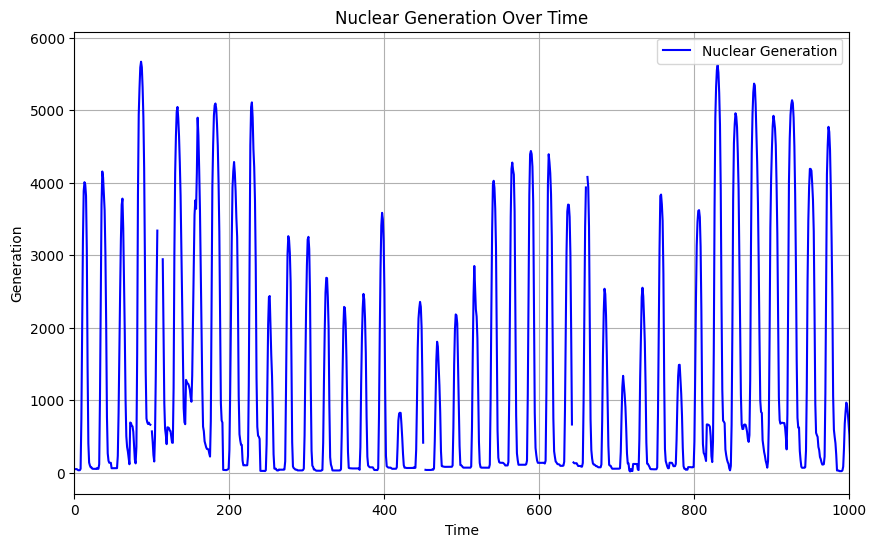

In [7]:
print(df['generation nuclear'])
plt.figure(figsize=(10, 6))

plt.plot(df['generation solar'], label='Nuclear Generation',color = 'blue')

# plot tht tittle 
plt.title('Nuclear Generation Over Time')
plt.xlabel('Time') 
plt.ylabel('Generation')
plt.legend()   
plt.xlim(0, 1000)

plt.grid(True)
plt.show()


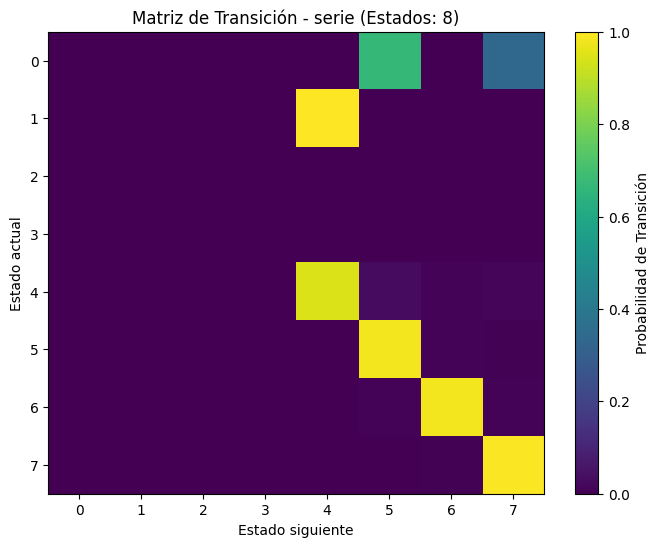

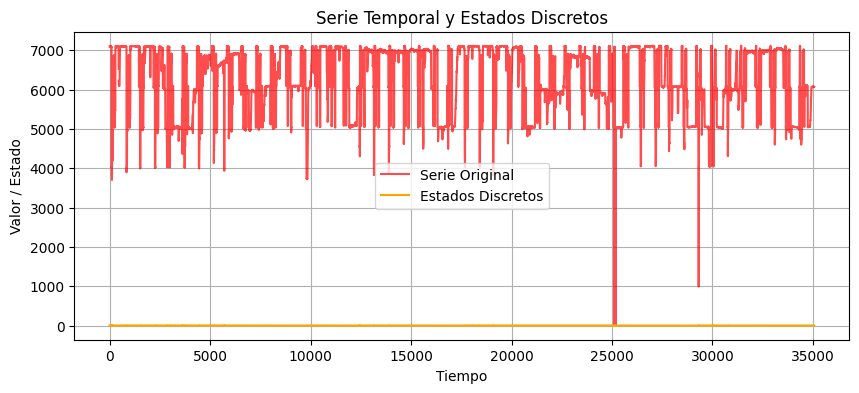

In [8]:
transMatrixProof = create_transition_matrix(df['generation nuclear'], N)
# Mostrar la matriz de transición
plt.figure(figsize=(8, 6))
plt.imshow(transMatrixProof, cmap='viridis', aspect='auto')
plt.colorbar(label="Probabilidad de Transición")
plt.title(f"Matriz de Transición - serie (Estados: {N})")
plt.xlabel("Estado siguiente")
plt.ylabel("Estado actual")
plt.xticks(range(N))
plt.yticks(range(N))
plt.grid(False)
plt.show()
states= np.digitize(df['generation nuclear'], np.linspace(df['generation nuclear'].min(), df['generation nuclear'].max(), N + 1)) - 1
states = np.clip(states, 0 , N - 1)
# Visualizar la serie temporal
# Visualizar la serie temporal
plt.figure(figsize=(10, 4))
plt.plot(df['generation nuclear'], label="Serie Original", color="red", alpha=0.7)
plt.step(range(len(states)), states, label="Estados Discretos", color="orange", where="mid")
plt.title("Serie Temporal y Estados Discretos")
plt.xlabel("Tiempo")
plt.ylabel("Valor / Estado")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# just proof of my transition matrix function 
# print(create_transition_matrix(df['generation nuclear'].dropna().values, 2))  

## process for first pair 

In [10]:
# Procesamiento principal
def FirstPar():
    # Cargar datos
    df = load_energy_data()
    
    # selecting data time series and deleting the NaN values
    series = df['generation solar'].dropna().values 
    series2= df['total load actual'].dropna().values 
    
    # Crear matriz de transición 8x8
    trans_matrix = create_transition_matrix(series, num_states=8)
    trans_matrix2 = create_transition_matrix(series2, num_states=8)



    # Compute column sums for each transition matrix
    column_sums_1 = trans_matrix.sum(axis=0)  # Column-wise sum for matrix 1
    column_sums_2 = trans_matrix2.sum(axis=0)  # Column-wise sum for matrix 2

    
    # visualization 

    fig, axes = plt.subplots( 3, 2, figsize = (12,15)) # 3 rows and 2 columns

    #heat map for T1 and T2

    # Heatmap for Transition Matrix 1
    im1 = axes[0, 0].imshow(trans_matrix, cmap="viridis", aspect="auto")
    axes[0, 0].set_title("Transition Matrix 1 Heatmap")
    fig.colorbar(im1, ax=axes[0, 0])
    axes[0, 0].set_xlabel("To State")
    axes[0, 0].set_ylabel("From State")

    # Mostrar valores en las celdas para Transition Matrix 1
    for i in range(trans_matrix.shape[0]):
        for j in range(trans_matrix.shape[1]):
            axes[0, 0].text(j, i, f"{trans_matrix[i, j]:.2f}", 
                            ha="center", va="center", color="white")


    # Bar plot for Column Sums of Transition Matrix 1
    axes[1, 0].bar(range(N), column_sums_1/column_sums_1.sum(axis=0), color="blue", alpha=0.7)
    axes[1, 0].set_title("Column Sums of Transition Matrix 1")
    axes[1, 0].set_xlabel("Column Index")
    axes[1, 0].set_ylabel("Sum")


    # Heatmap for Transition Matrix 2
    im2 = axes[0, 1].imshow(trans_matrix2, cmap="viridis", aspect="auto")
    axes[0, 1].set_title("Transition Matrix 2 Heatmap")
    fig.colorbar(im2, ax=axes[0, 1])
    axes[0, 1].set_xlabel("To State")
    axes[0, 1].set_ylabel("From State")

    # Mostrar valores en las celdas para Transition Matrix 2
    for i in range(trans_matrix2.shape[0]):
        for j in range(trans_matrix2.shape[1]):
            axes[0, 1].text(j, i, f"{trans_matrix2[i, j]:.2f}", 
                            ha="center", va="center", color="white")
        

    # Bar plot for Column Sums of Transition Matrix 2
    axes[1, 1].bar(range(N), column_sums_2/column_sums_2.sum(axis=0), color="green", alpha=0.7)
    axes[1, 1].set_title("Column Sums of Transition Matrix 2")
    axes[1, 1].set_xlabel("Column Index")
    axes[1, 1].set_ylabel("Sum")





    # Compute eigenvalues for each transition matrix
    eigenvalues_1 = np.linalg.eigvals(trans_matrix)
    axes[2, 0].bar(range(len(eigenvalues_1)), eigenvalues_1.real, color="blue", alpha=0.7)
    axes[2, 0].set_title("Eigenvalues of Transition Matrix 1")
    axes[2, 0].set_xlabel("Eigenvalue Index")
    axes[2, 0].set_ylabel("Real Part")

    eigenvalues_2 = np.linalg.eigvals(trans_matrix2)
    axes[2, 1].bar(range(len(eigenvalues_2)), eigenvalues_2.real, color="green", alpha=0.7)
    axes[2, 1].set_title("Eigenvalues of Transition Matrix 2")
    axes[2, 1].set_xlabel("Eigenvalue Index")
    axes[2, 1].set_ylabel("Real Part")

    plt.tight_layout()
    plt.show()



    # Compute joint transition matrix
    joint_matrix = np.dot(trans_matrix2, trans_matrix)  # Matrix multiplication

    # Compute column sums for the joint matrix
    column_sums_joint = joint_matrix.sum(axis=0)

    # Compute eigenvalues for the joint matrix
    eigenvalues_joint = np.linalg.eigvals(joint_matrix)

    # Plot heatmap, column sums, and eigenvalues for the joint matrix
    fig, axes = plt.subplots(3, 1, figsize=(10, 15))  # 3 rows, 1 column

    # Heatmap for Joint Transition Matrix
    im = axes[0].imshow(joint_matrix, cmap="viridis", aspect="auto")
    axes[0].set_title("Joint Transition Matrix Heatmap")
    fig.colorbar(im, ax=axes[0])
    axes[0].set_xlabel("To State")
    axes[0].set_ylabel("From State")

    # Bar plot for Column Sums of Joint Transition Matrix
    axes[1].bar(range(N), column_sums_joint/column_sums_joint.sum(axis=0), color="blue", alpha=0.7)
    axes[1].set_title("Column Sums of Joint Transition Matrix")
    axes[1].set_xlabel("Column Index")
    axes[1].set_ylabel("Sum")

    # Bar plot for Eigenvalues of Joint Transition Matrix
    axes[2].bar(range(len(eigenvalues_joint)), eigenvalues_joint.real, color="green", alpha=0.7)
    axes[2].set_title("Eigenvalues of Joint Transition Matrix")
    axes[2].set_xlabel("Eigenvalue Index")
    axes[2].set_ylabel("Real Part")



        
    # Compute the conditional transition matrix
    conditional_matrix =np.dot(trans_matrix,trans_matrix2) # Element-wise product
    pb = np.sum(conditional_matrix, axis=1, keepdims=True)  # Row-wise sum
    conditional_matrix = conditional_matrix / pb # Normalize by row sums
    conditional_matrix /= conditional_matrix.sum(axis=1, keepdims=True)  # Normalize rows to sum to 1

    # Compute column sums for the conditional matrix
    column_sums_conditional = conditional_matrix.sum(axis=0)

    # Compute eigenvalues for the conditional matrix
    eigenvalues_conditional = np.linalg.eigvals(conditional_matrix)

    # Plot heatmap, column sums, and eigenvalues for the conditional matrix
    fig, axes = plt.subplots(3, 1, figsize=(12, 15))  # 3 rows, 1 column

    # Heatmap for Conditional Transition Matrix
    im = axes[0].imshow(conditional_matrix, cmap="viridis", aspect="auto")
    axes[0].set_title("Conditional Transition Matrix Heatmap")
    fig.colorbar(im, ax=axes[0])
    axes[0].set_xlabel("To State")
    axes[0].set_ylabel("From State")

    # Bar plot for Column Sums of Conditional Transition Matrix
    axes[1].bar(range(N), column_sums_conditional/column_sums_joint.sum(axis=0), color="blue", alpha=0.7)
    axes[1].set_title("Column Sums of Conditional Transition Matrix")
    axes[1].set_xlabel("Column Index")
    axes[1].set_ylabel("Sum")

    # Bar plot for Eigenvalues of Conditional Transition Matrix
    axes[2].bar(range(len(eigenvalues_conditional)), eigenvalues_conditional.real, color="green", alpha=0.7)
    axes[2].set_title("Eigenvalues of Conditional Transition Matrix")
    axes[2].set_xlabel("Eigenvalue Index")
    axes[2].set_ylabel("Real Part")


    plt.tight_layout()
    plt.show()
    

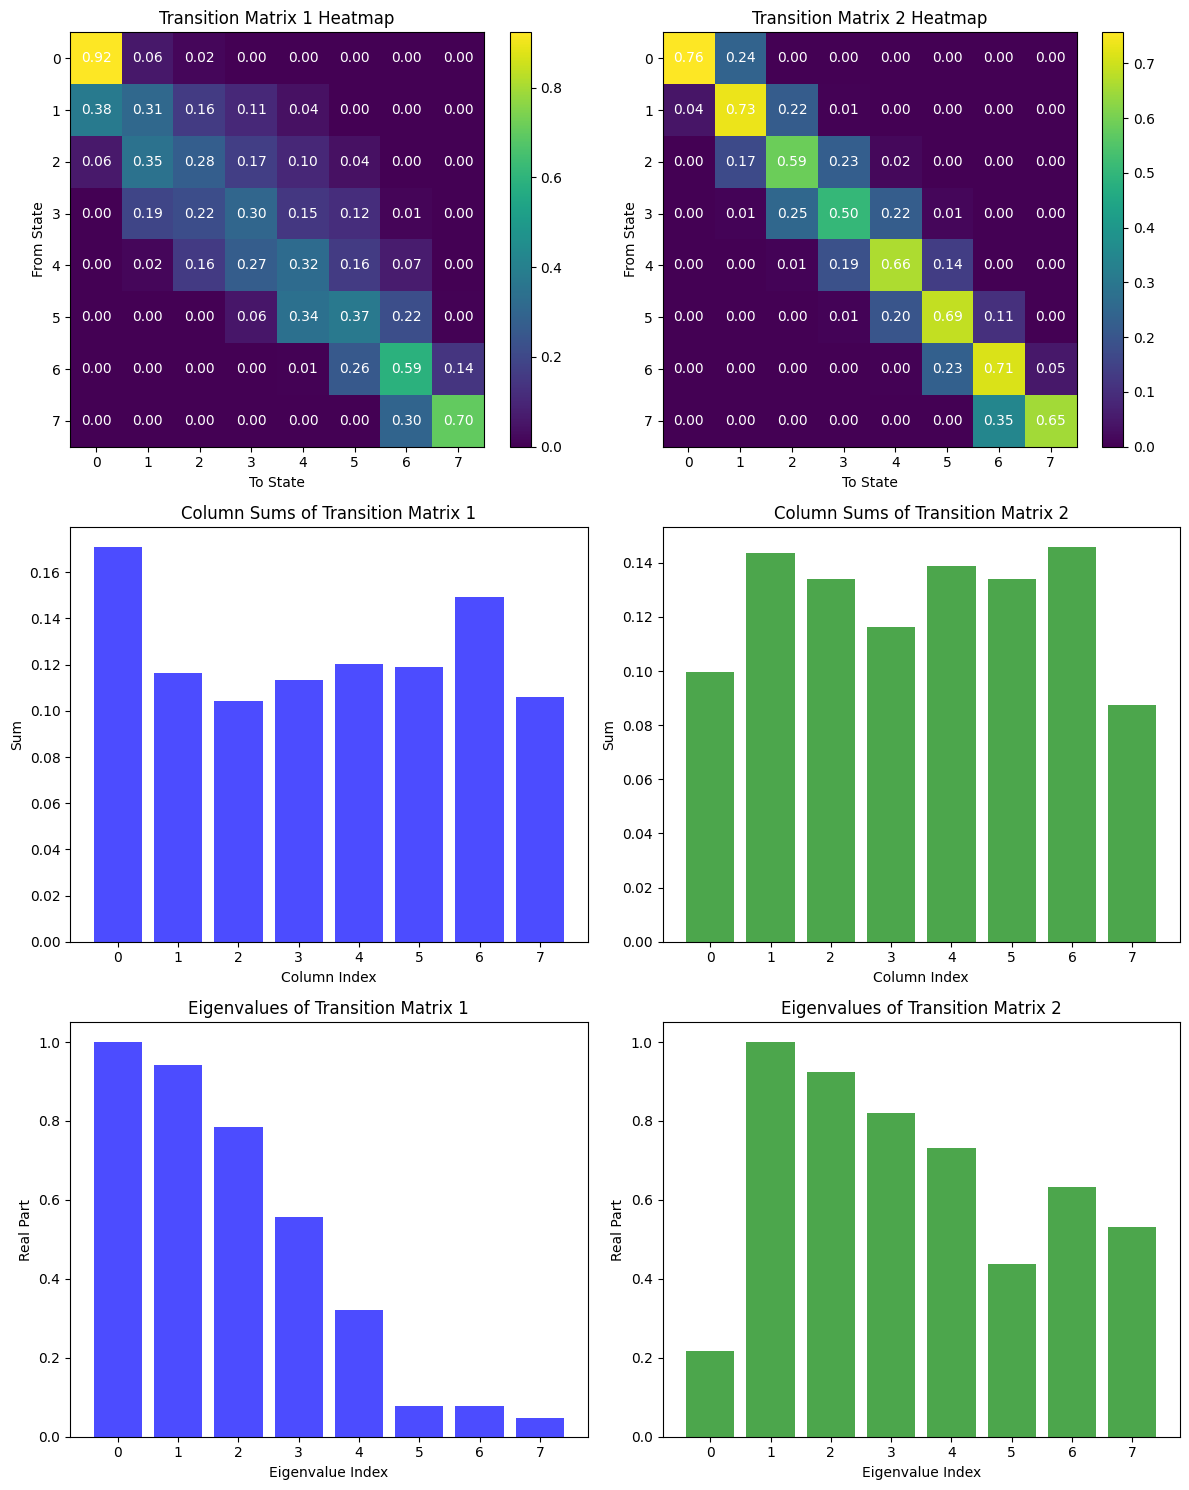

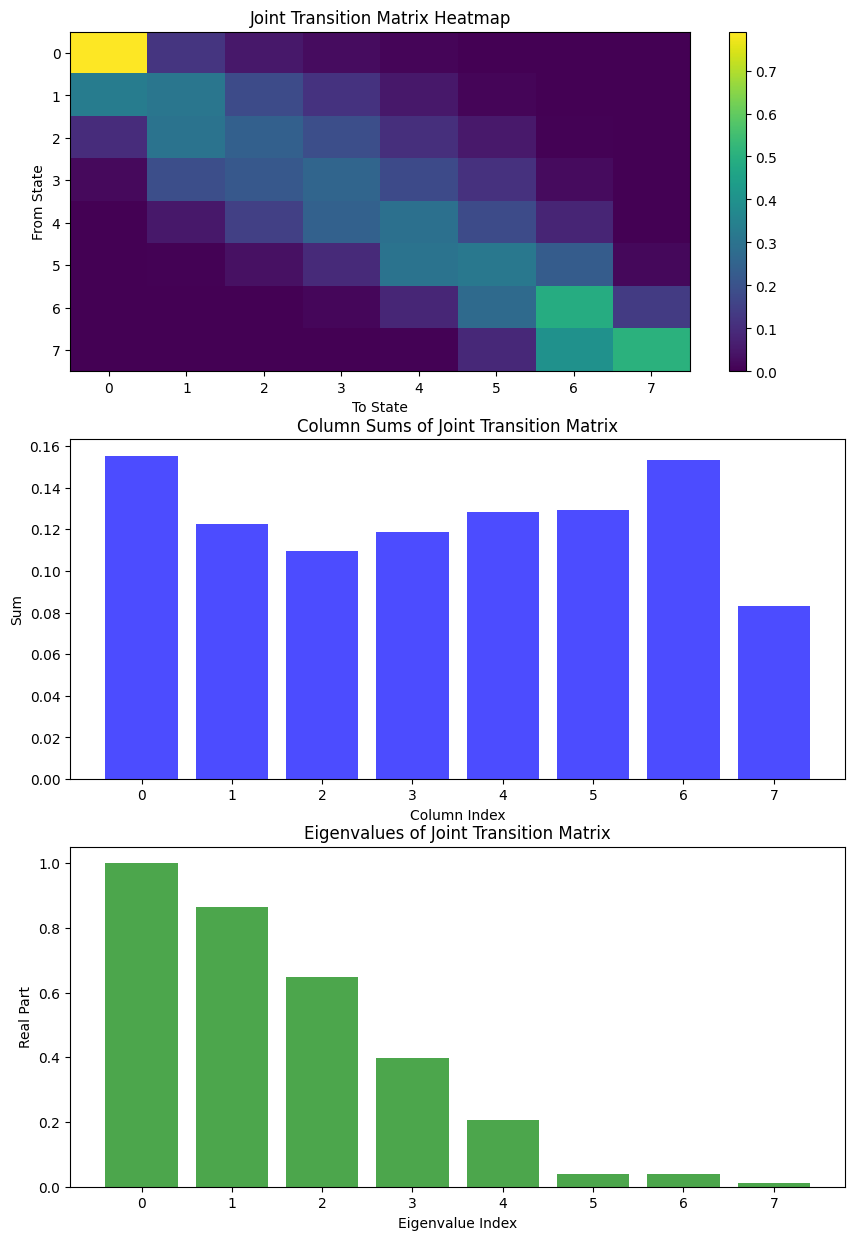

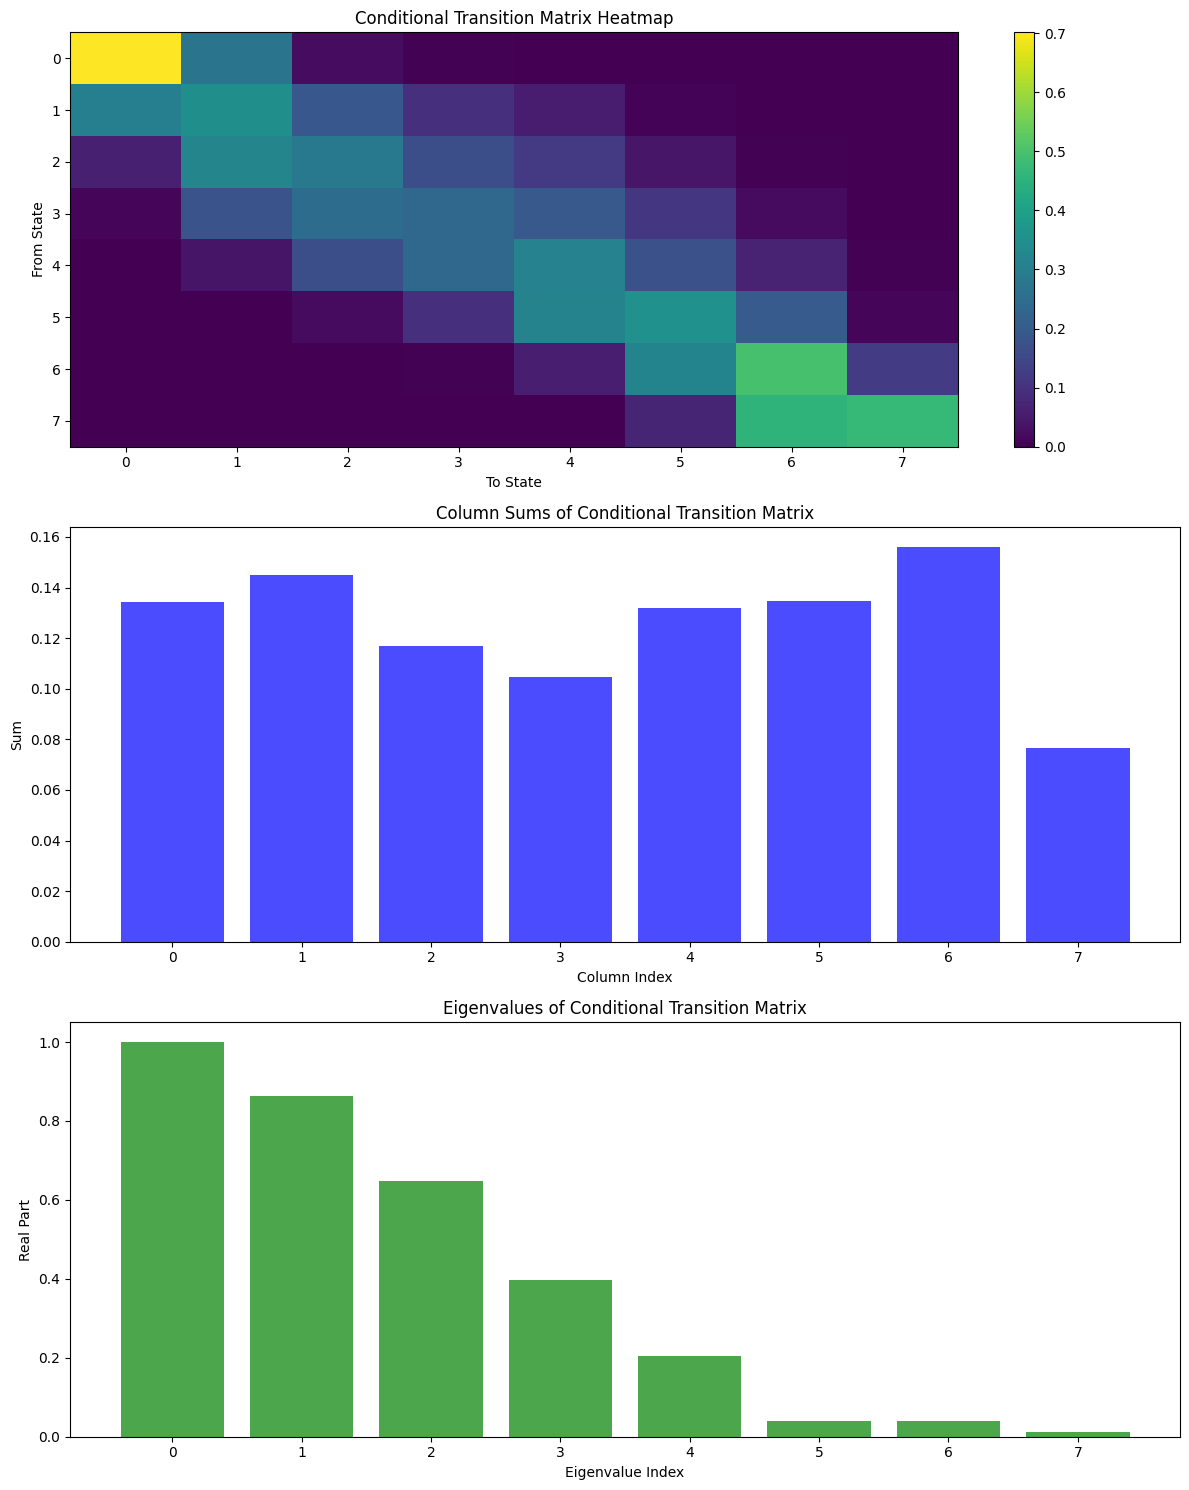

In [11]:

if __name__ == "__main__":
    FirstPar()


## process for second pair 

In [12]:
# Procesamiento principal
def secondPair():
    # Cargar datos
    df = load_energy_data()
    
    # Seleccionar serie temporal (cambiar según necesidad)
    series3 = df['generation nuclear'].values  # o 'total_load_actual'
    series4= df['price actual'].values
    
    # Crear matriz de transición 8x8
    trans_matrix3 = create_transition_matrix(series3, num_states=8)
    trans_matrix4 = create_transition_matrix(series4, num_states=8)



    # Compute column sums for each transition matrix
    column_sums_3 = trans_matrix3.sum(axis=0)  # Column-wise sum for matrix 1
    column_sums_4 = trans_matrix4.sum(axis=0)  # Column-wise sum for matrix 2

    
    # visualization 

    fig, axes = plt.subplots( 3, 2, figsize = (12,15)) # 3 rows and 2 columns

    #heat map for T1 and T2

    # Heatmap for Transition Matrix 1
    im1 = axes[0, 0].imshow(trans_matrix3, cmap="viridis", aspect="auto")
    axes[0, 0].set_title("Transition Matrix 3 Heatmap")
    fig.colorbar(im1, ax=axes[0, 0])
    axes[0, 0].set_xlabel("To State")
    axes[0, 0].set_ylabel("From State")

    # Mostrar valores en las celdas para Transition Matrix 1
    for i in range(trans_matrix3.shape[0]):
        for j in range(trans_matrix3.shape[1]):
            axes[0, 0].text(j, i, f"{trans_matrix3[i, j]:.2f}", 
                            ha="center", va="center", color="white")


    # Bar plot for Column Sums of Transition Matrix 1
    axes[1, 0].bar(range(N), column_sums_3/column_sums_3.sum(axis=0), color="blue", alpha=0.7)
    axes[1, 0].set_title("Column Sums of Transition Matrix 3")
    axes[1, 0].set_xlabel("Column Index")
    axes[1, 0].set_ylabel("Sum")


    # Heatmap for Transition Matrix 2
    im2 = axes[0, 1].imshow(trans_matrix4, cmap="viridis", aspect="auto")
    axes[0, 1].set_title("Transition Matrix 4 Heatmap")
    fig.colorbar(im2, ax=axes[0, 1])
    axes[0, 1].set_xlabel("To State")
    axes[0, 1].set_ylabel("From State")

    # Mostrar valores en las celdas para Transition Matrix 2
    for i in range(trans_matrix4.shape[0]):
        for j in range(trans_matrix4.shape[1]):
            axes[0, 1].text(j, i, f"{trans_matrix4[i, j]:.2f}", 
                            ha="center", va="center", color="white")
        

    # Bar plot for Column Sums of Transition Matrix 2
    axes[1, 1].bar(range(N), column_sums_4/column_sums_4.sum(axis=0), color="green", alpha=0.7)
    axes[1, 1].set_title("Column Sums of Transition Matrix 4")
    axes[1, 1].set_xlabel("Column Index")
    axes[1, 1].set_ylabel("Sum")





    # Compute eigenvalues for each transition matrix
    eigenvalues_3 = np.linalg.eigvals(trans_matrix3)
    axes[2, 0].bar(range(len(eigenvalues_3)), eigenvalues_3.real, color="blue", alpha=0.7)
    axes[2, 0].set_title("Eigenvalues of Transition Matrix 3")
    axes[2, 0].set_xlabel("Eigenvalue Index")
    axes[2, 0].set_ylabel("Real Part")

    eigenvalues_4 = np.linalg.eigvals(trans_matrix4)
    axes[2, 1].bar(range(len(eigenvalues_4)), eigenvalues_4.real, color="green", alpha=0.7)
    axes[2, 1].set_title("Eigenvalues of Transition Matrix 4")
    axes[2, 1].set_xlabel("Eigenvalue Index")
    axes[2, 1].set_ylabel("Real Part")

    plt.tight_layout()
    plt.show()



    # Compute joint transition matrix
    joint_matrix2 = np.dot(trans_matrix3, trans_matrix4)  # Matrix multiplication

    # Compute column sums for the joint matrix
    column_sums_joint2 = joint_matrix2.sum(axis=0)

    # Compute eigenvalues for the joint matrix
    eigenvalues_joint2 = np.linalg.eigvals(joint_matrix2)

    # Plot heatmap, column sums, and eigenvalues for the joint matrix
    fig, axes = plt.subplots(3, 1, figsize=(10, 15))  # 3 rows, 1 column

    # Heatmap for Joint Transition Matrix
    im = axes[0].imshow(joint_matrix2, cmap="viridis", aspect="auto")
    axes[0].set_title("Joint Transition Matrix 2 Heatmap ")
    fig.colorbar(im, ax=axes[0])
    axes[0].set_xlabel("To State")
    axes[0].set_ylabel("From State")

    # Bar plot for Column Sums of Joint Transition Matrix
    axes[1].bar(range(N), column_sums_joint2/column_sums_joint2.sum(axis=0), color="blue", alpha=0.7)
    axes[1].set_title("Column Sums of Joint Transition Matrix 2")
    axes[1].set_xlabel("Column Index")
    axes[1].set_ylabel("Sum")

    # Bar plot for Eigenvalues of Joint Transition Matrix
    axes[2].bar(range(len(eigenvalues_joint2)), eigenvalues_joint2.real, color="green", alpha=0.7)
    axes[2].set_title("Eigenvalues of Joint Transition Matrix 2")
    axes[2].set_xlabel("Eigenvalue Index")
    axes[2].set_ylabel("Real Part")






            
    # Compute the conditional transition matrix
    conditional_matrix =np.dot(trans_matrix3,trans_matrix4) # Element-wise product
    pb = np.sum(conditional_matrix, axis=1, keepdims=True)  # Row-wise sum
    conditional_matrix = conditional_matrix / pb # Normalize by row sums
    conditional_matrix /= conditional_matrix.sum(axis=1, keepdims=True)  # Normalize rows to sum to 1

    # Compute column sums for the conditional matrix
    column_sums_conditional = conditional_matrix.sum(axis=0)

    # Compute eigenvalues for the conditional matrix
    eigenvalues_conditional = np.linalg.eigvals(conditional_matrix)

    # Plot heatmap, column sums, and eigenvalues for the conditional matrix
    fig, axes = plt.subplots(3, 1, figsize=(12, 15))  # 3 rows, 1 column

    # Heatmap for Conditional Transition Matrix
    im = axes[0].imshow(conditional_matrix, cmap="viridis", aspect="auto")
    axes[0].set_title("Conditional Transition Matrix Heatmap")
    fig.colorbar(im, ax=axes[0])
    axes[0].set_xlabel("To State")
    axes[0].set_ylabel("From State")

    # Bar plot for Column Sums of Conditional Transition Matrix
    axes[1].bar(range(N), column_sums_conditional/column_sums_joint2.sum(axis=0), color="blue", alpha=0.7)
    axes[1].set_title("Column Sums of Conditional Transition Matrix")
    axes[1].set_xlabel("Column Index")
    axes[1].set_ylabel("Sum")

    # Bar plot for Eigenvalues of Conditional Transition Matrix
    axes[2].bar(range(len(eigenvalues_conditional)), eigenvalues_conditional.real, color="green", alpha=0.7)
    axes[2].set_title("Eigenvalues of Conditional Transition Matrix")
    axes[2].set_xlabel("Eigenvalue Index")
    axes[2].set_ylabel("Real Part")


    plt.tight_layout()
    plt.show()

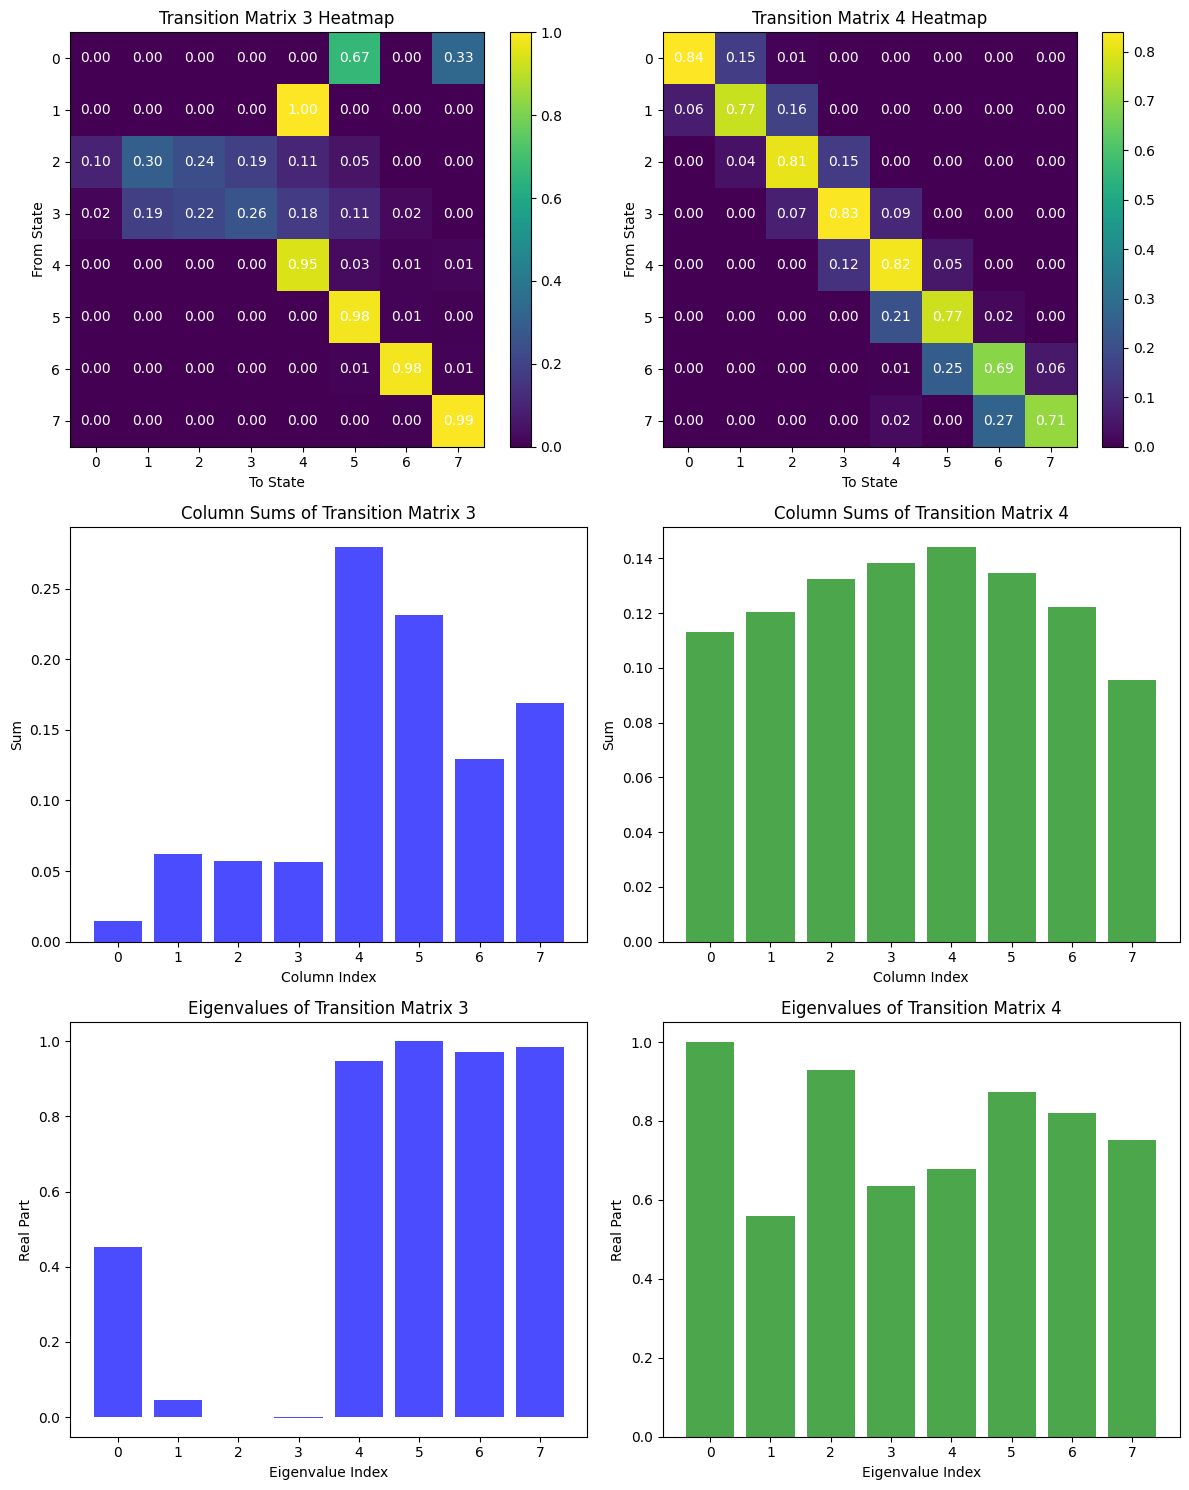

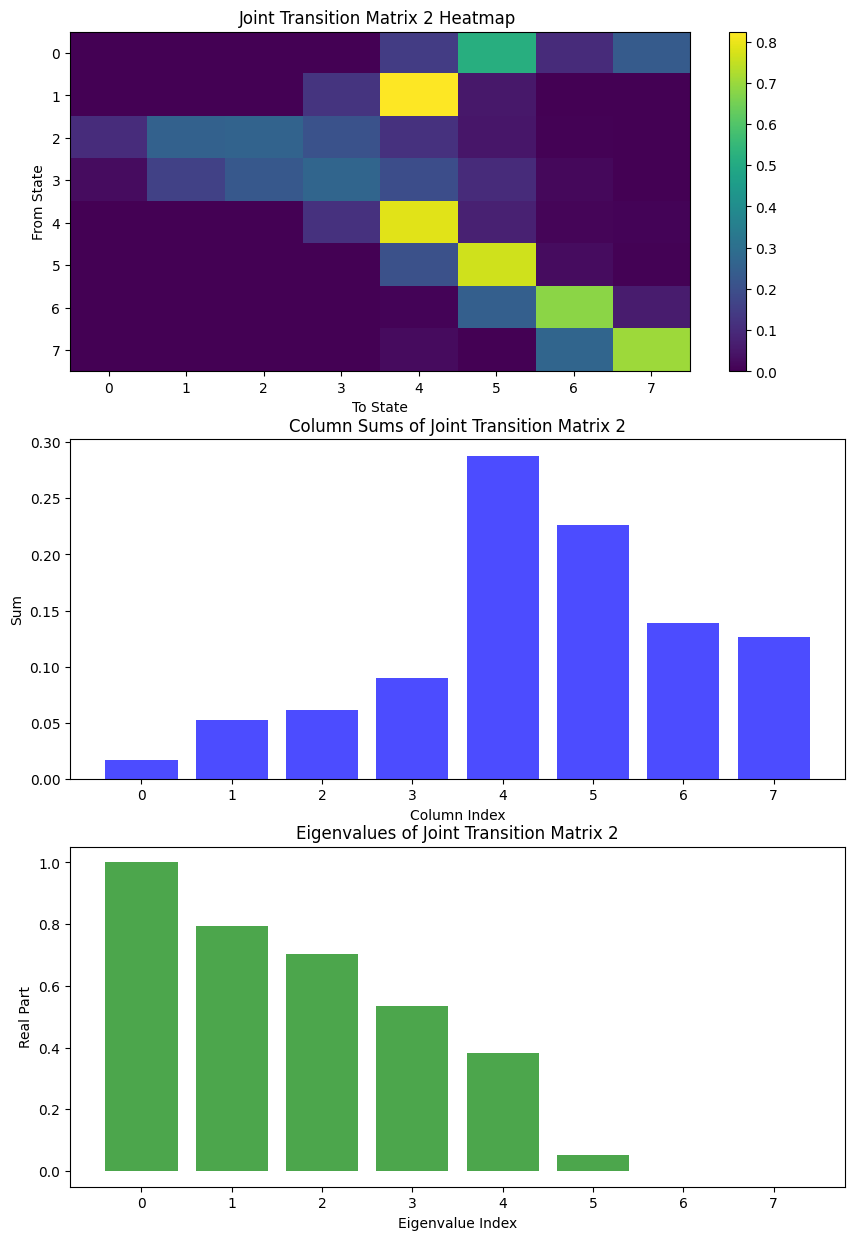

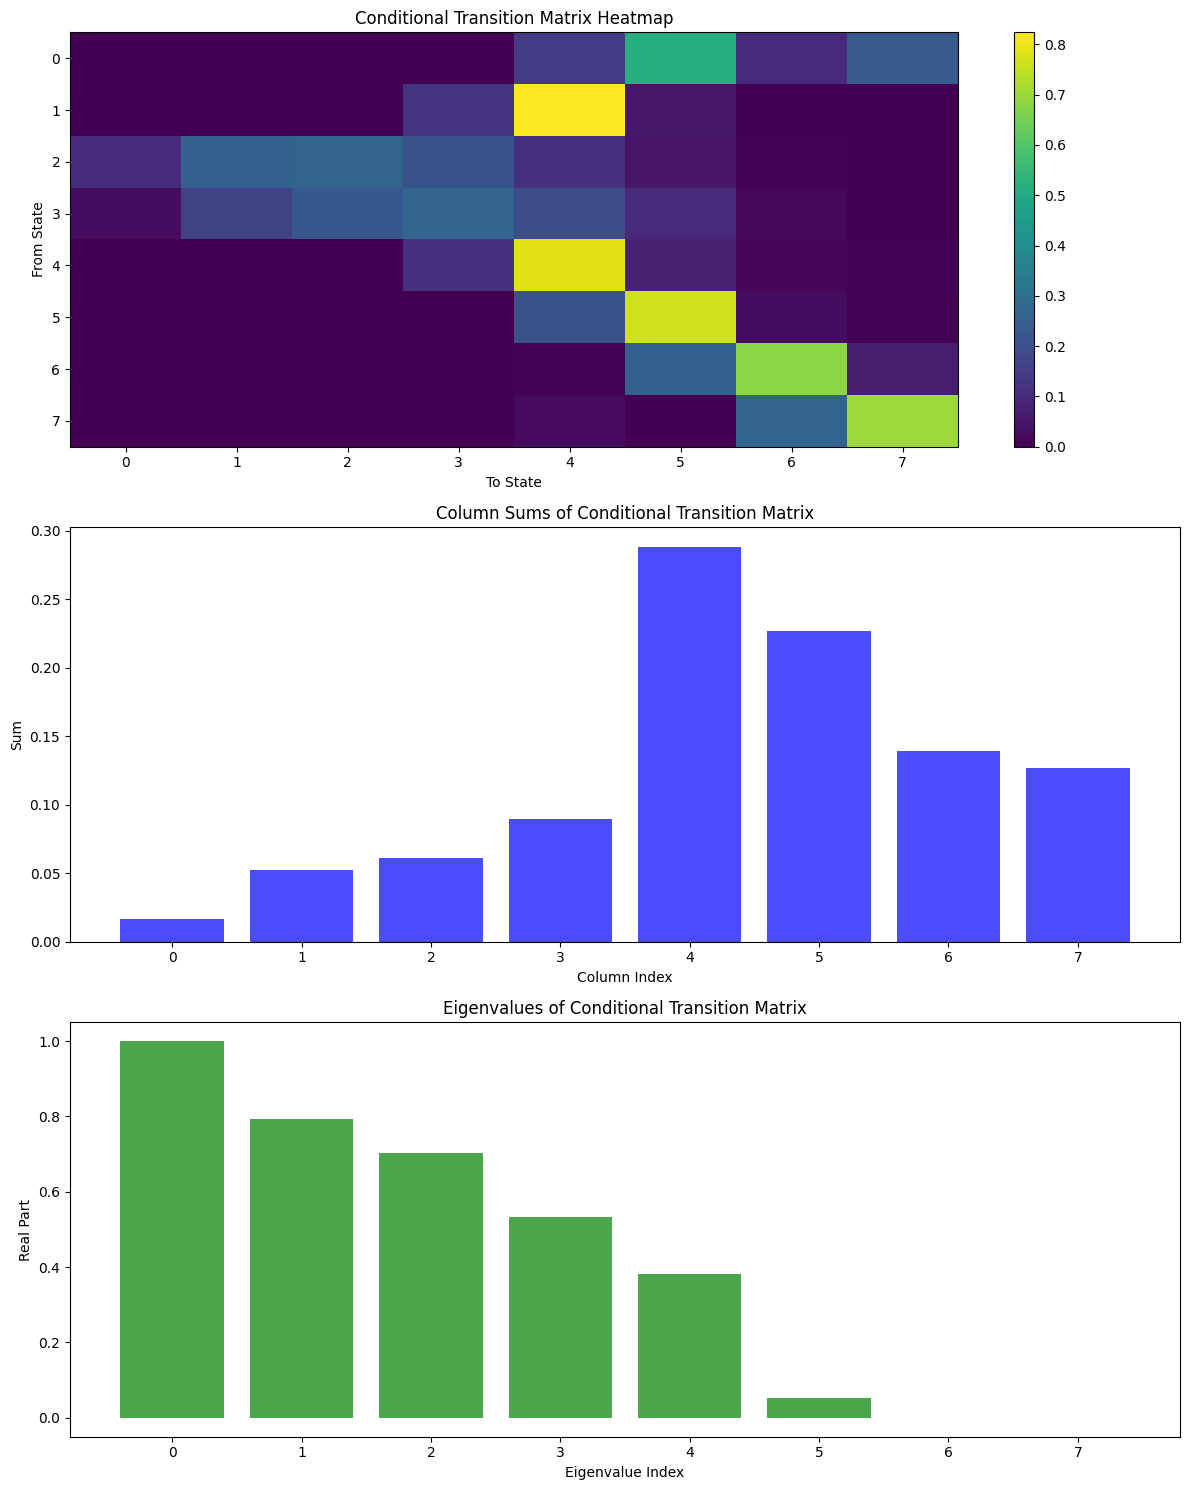

In [13]:

if __name__ == "__main__":
    secondPair()

## making on it on torch :


packages import 

In [14]:
import torch
import matplotlib.pyplot as plt

function definition

In [15]:


def load_energy_data():
    """
    Carga datos de energía desde un archivo CSV y
      devuelve un diccionario con las series temporales.
    """
   

    df = pd.read_csv("dataset\energy_dataset.csv")
    data = {
        'generation_solar': df['generation solar'].dropna().values,
        'generation_nuclear': df['generation nuclear'].dropna().values,
        'price_actual': df['price actual'].dropna().values,
        'total_load_actual': df['total load actual'].dropna().values
    }
    return data



to create  transition matrices

In [16]:

def create_transition_matrix(series, num_states, device='cpu'):
    """
    Crea una matriz de transición basada en una serie temporal.
    """
    series = torch.tensor(series, device=device)
    bins = torch.linspace(series.min(), series.max(), num_states + 1, device=device)
    states = torch.bucketize(series, bins) - 1  # Asigna estados
    states = torch.clamp(states, 0, num_states - 1)  # Asegura que los índices estén en el rango válido

    trans_matrix = torch.zeros((num_states, num_states), device=device)

    for i in range(len(states) - 1):
        trans_matrix[states[i], states[i + 1]] += 1

    # Normaliza filas y evita divisiones por cero
    row_sums = trans_matrix.sum(dim=1, keepdim=True)
    row_sums[row_sums == 0] = 1  # Evita divisiones por cero
    trans_matrix /= row_sums
    return trans_matrix



in order to plot the matrices:


In [17]:
def plot_matrix(matrix, title, ax, cmap="viridis"):
    """
    Dibuja un heatmap para una matriz.
    """
    im = ax.imshow(matrix.cpu().numpy(), cmap=cmap, aspect="auto")
    ax.set_title(title)
    ax.set_xlabel("To State")
    ax.set_ylabel("From State")
    return im

computing the joint matrix 

In [18]:

def compute_joint_matrix(matrix1, matrix2):
    """
    Calcula la matriz conjunta como el producto matricial de dos matrices de transición.
    """
    return torch.mm(matrix1, matrix2)

now compute the conditional matrix

In [19]:

def compute_conditional_matrix(matrix1, matrix2):
    """
    Calcula la matriz condicional como el producto elemento a elemento (Hadamard product)
    de dos matrices de transición, seguido de la normalización por filas.
    """
    conditional_matrix = matrix1 * matrix2
    row_sums = conditional_matrix.sum(dim=1, keepdim=True)
    row_sums[row_sums == 0] = 1  # Evita divisiones por cero
    conditional_matrix /= row_sums
    return conditional_matrix


to visualize sumn columns and eigen values

In [20]:


def print_column_sums_and_eigenvalues(matrix, title):
    """
    Imprime las sumas de columnas y los valores propios (eigenvalues) de una matriz.
    """
    column_sums = matrix.sum(dim=0)
    eigenvalues = torch.linalg.eigvals(matrix)

    print(f"\n{title} Column Sums:")
    print(column_sums.cpu().numpy())

    print(f"\n{title} Eigenvalues (Real Part):")
    print(eigenvalues.real.cpu().numpy())

    return eigenvalues.real.cpu().numpy()

main programm

In [21]:
def main():
    # Configuración
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    num_states = 8

    # Cargar datos
    data = load_energy_data()
    series_names = ['generation_solar', 'total_load_actual', 'generation_nuclear', 'price_actual']

    # Crear matrices de transición para cada serie
    transition_matrices = {}
    for name in series_names:
        transition_matrices[name] = create_transition_matrix(data[name], num_states, device)

    # Visualización de matrices de transición
    fig, axes = plt.subplots(len(series_names), 2, figsize=(15, 5 * len(series_names)))

    for i, name in enumerate(series_names):
        matrix = transition_matrices[name]
        column_sums = matrix.sum(dim=0)

        # Heatmap
        im = plot_matrix(matrix, f"{name} Transition Matrix Heatmap", axes[i, 0])
        fig.colorbar(im, ax=axes[i, 0])

        # Column sums
        axes[i, 1].bar(range(num_states), (column_sums / column_sums.sum()).cpu().numpy(), color="blue", alpha=0.7)
        axes[i, 1].set_title(f"{name} Column Sums")
        axes[i, 1].set_xlabel("Column Index")
        axes[i, 1].set_ylabel("Sum")

    plt.tight_layout()
    plt.show()

    # Calcular y visualizar matrices conjuntas
    joint_pairs = [
        ('generation_solar', 'total_load_actual'),
        ('generation_nuclear', 'price_actual'),
        ('total_load_actual', 'generation_solar'),
        ('price_actual', 'generation_nuclear')
    ]

    for pair in joint_pairs:
        matrix1 = transition_matrices[pair[0]]
        matrix2 = transition_matrices[pair[1]]

        joint_matrix = compute_joint_matrix(matrix1, matrix2)

        # Visualización de la matriz conjunta
        plt.figure(figsize=(8, 6))
        plt.imshow(joint_matrix.cpu().numpy(), cmap="viridis", aspect="auto")
        plt.colorbar()
        plt.title(f"Joint Transition Matrix: {pair[0]} & {pair[1]}")
        plt.xlabel("To State")
        plt.ylabel("From State")
        plt.show()

        # Imprimir sumas de columnas y eigenvalues
        print_column_sums_and_eigenvalues(joint_matrix, f"Joint Matrix ({pair[0]} & {pair[1]})")

    # Calcular y visualizar matrices condicionales
    conditional_pairs = [
     ('generation_solar', 'total_load_actual'),
        ('generation_nuclear', 'price_actual'),
        ('total_load_actual', 'generation_solar'),
        ('price_actual', 'generation_nuclear')
    ]

    for pair in conditional_pairs:
        matrix1 = transition_matrices[pair[0]]
        matrix2 = transition_matrices[pair[1]]

        conditional_matrix = compute_conditional_matrix(matrix1, matrix2)

        # Visualización de la matriz condicional
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        # Heatmap de la matriz condicional
        im = axes[0].imshow(conditional_matrix.cpu().numpy(), cmap="viridis", aspect="auto")
        axes[0].set_title(f"Conditional Transition Matrix: {pair[0]} | {pair[1]}")
        axes[0].set_xlabel("To State")
        axes[0].set_ylabel("From State")
        fig.colorbar(im, ax=axes[0])

        # Mostrar sumas de columnas como gráfico de barras
        column_sums = conditional_matrix.sum(dim=0)
        axes[1].bar(range(num_states), (column_sums / column_sums.sum()).cpu().numpy(), color="blue", alpha=0.7)
        axes[1].set_title(f"Column Sums: {pair[0]} | {pair[1]}")
        axes[1].set_xlabel("Column Index")
        axes[1].set_ylabel("Sum")

        # Calcular e imprimir eigenvalues
        eigenvalues = print_column_sums_and_eigenvalues(conditional_matrix, f"Conditional Matrix ({pair[0]} | {pair[1]})")

        # Mostrar eigenvalues como gráfico de barras
        axes[2].bar(range(len(eigenvalues)), eigenvalues, color="green", alpha=0.7)
        axes[2].set_title(f"Eigenvalues: {pair[0]} | {pair[1]}")
        axes[2].set_xlabel("Eigenvalue Index")
        axes[2].set_ylabel("Real Part")

        plt.tight_layout()
        plt.show()

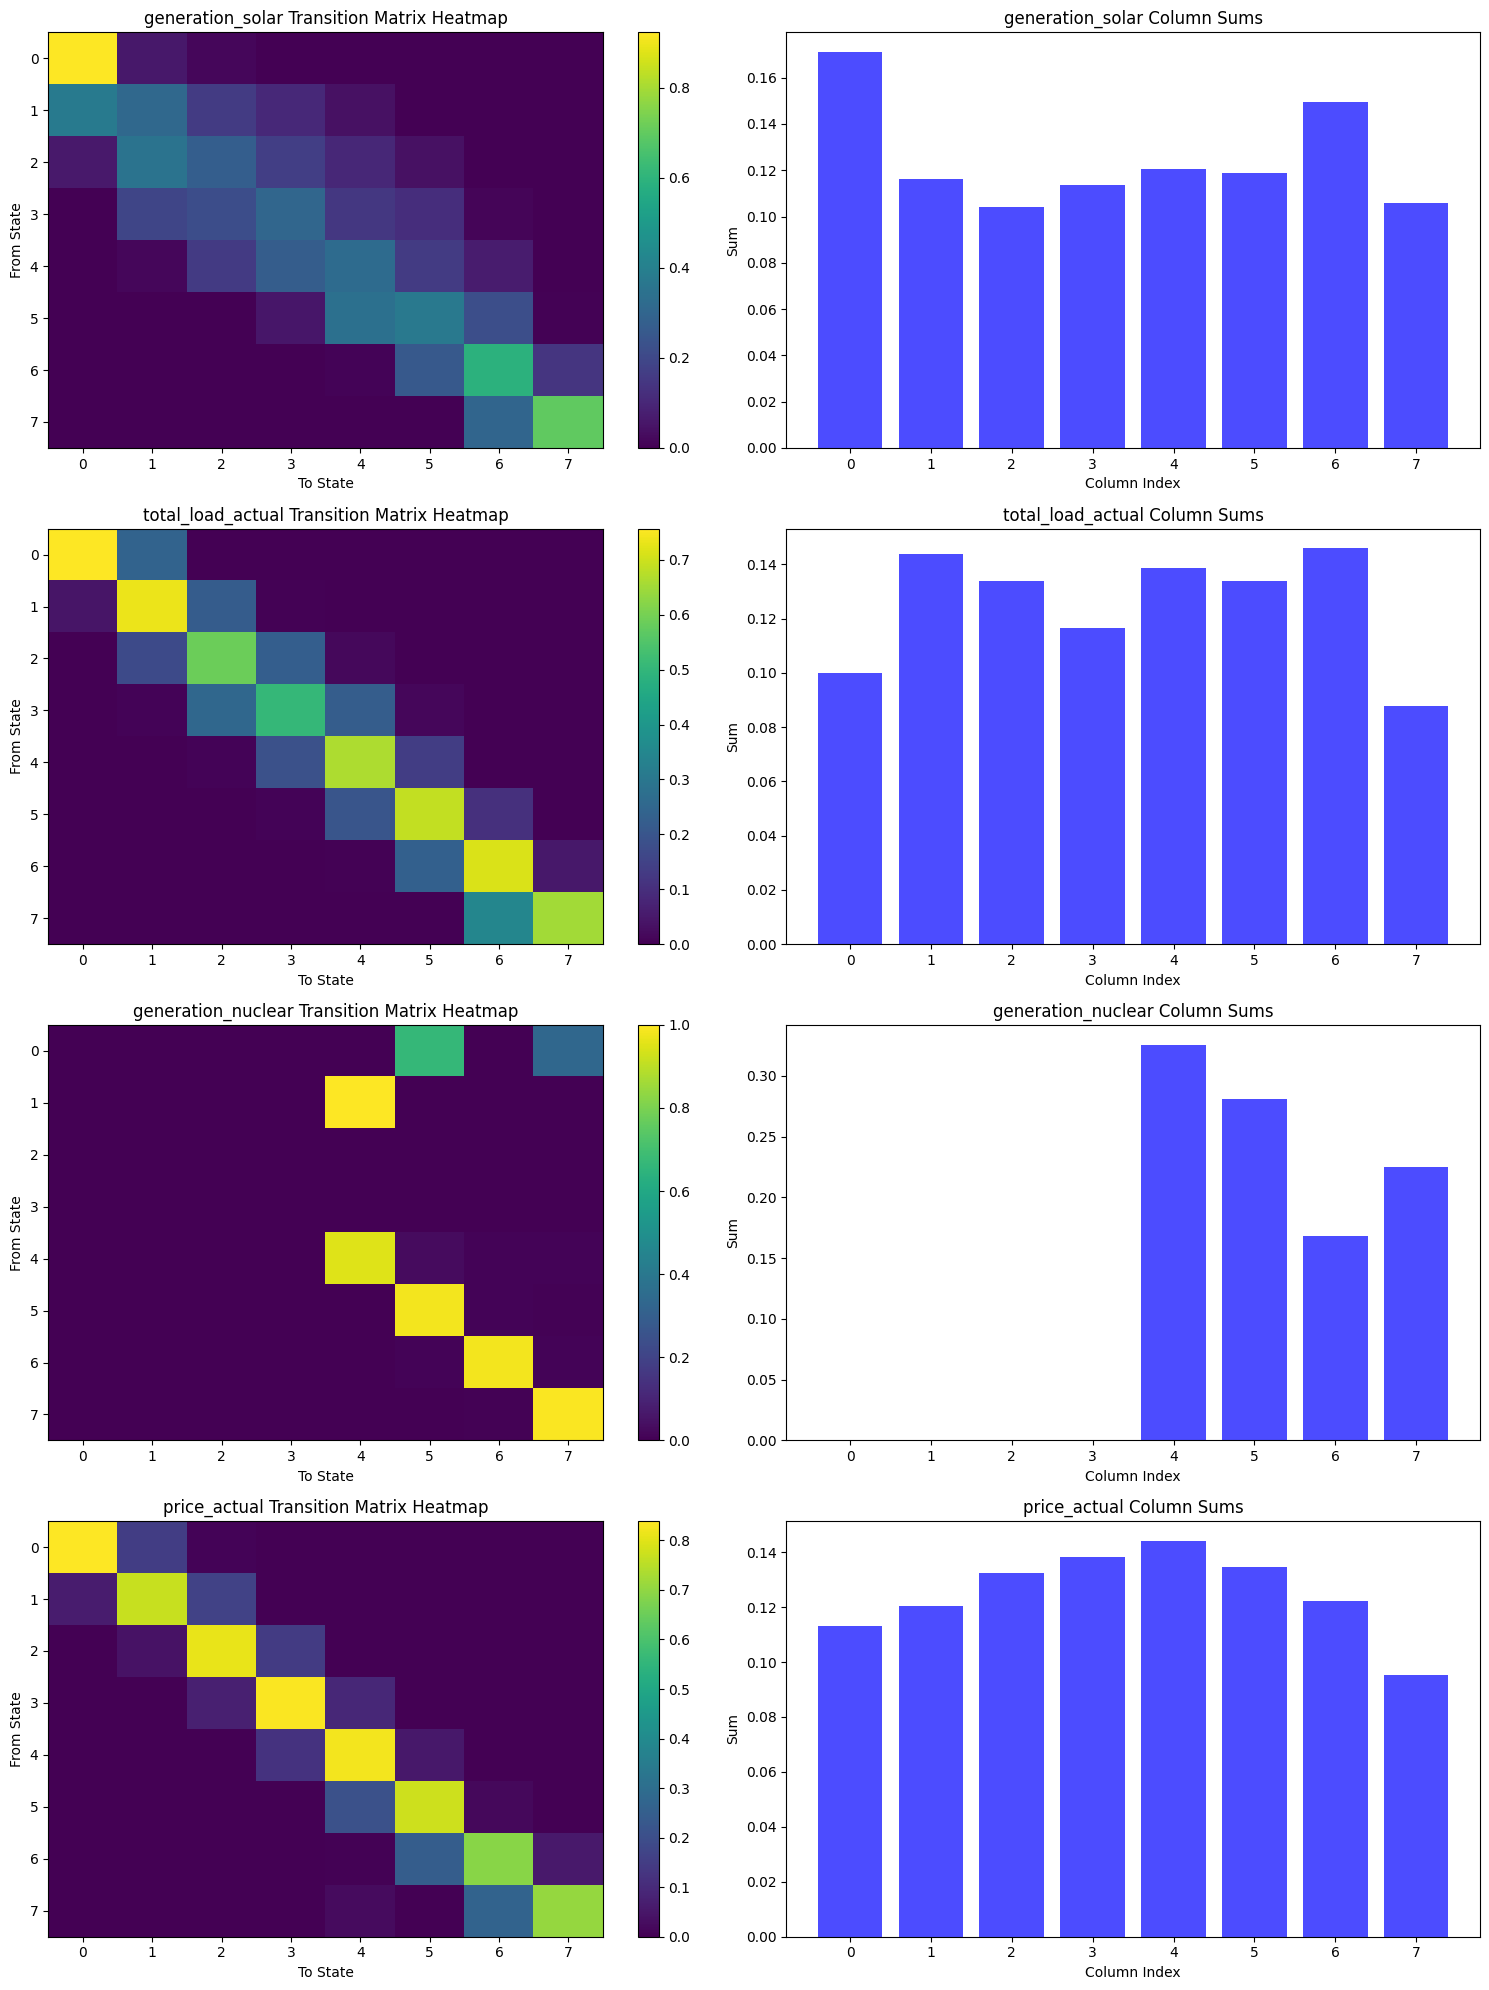

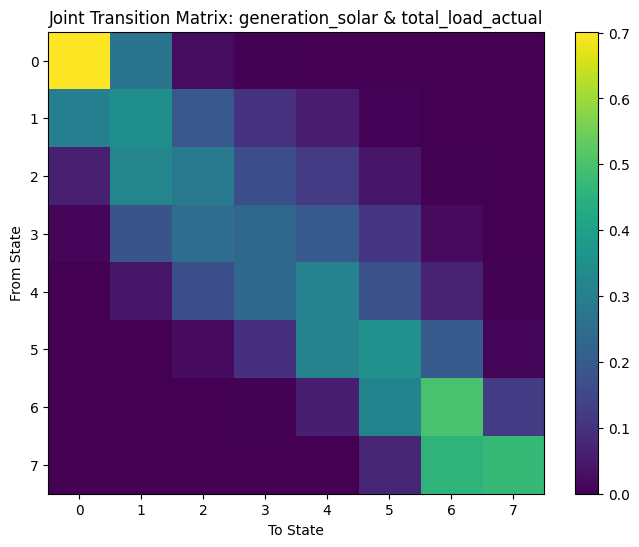


Joint Matrix (generation_solar & total_load_actual) Column Sums:
[1.074621   1.1578598  0.93421954 0.839543   1.0559154  1.0775644
 1.248809   0.61146826]

Joint Matrix (generation_solar & total_load_actual) Eigenvalues (Real Part):
[1.0000002  0.863129   0.6467758  0.3966627  0.20498393 0.0390863
 0.0390863  0.01151932]


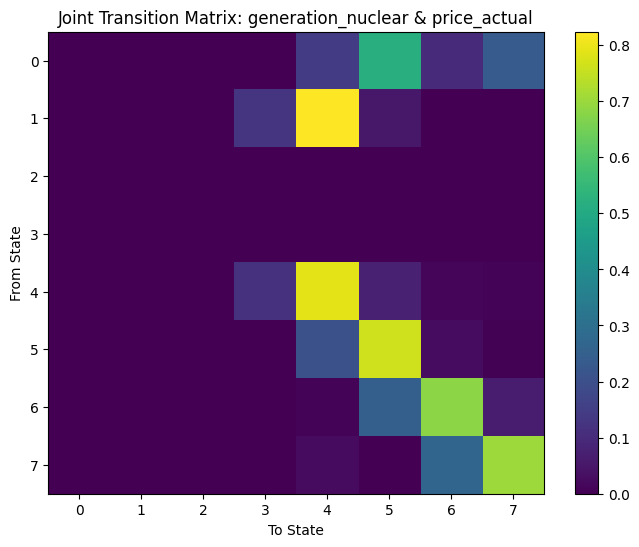


Joint Matrix (generation_nuclear & price_actual) Column Sums:
[3.8918690e-04 1.3925061e-03 8.7604619e-04 2.4007855e-01 1.9960914e+00
 1.6610789e+00 1.0889684e+00 1.0111250e+00]

Joint Matrix (generation_nuclear & price_actual) Eigenvalues (Real Part):
[-1.6828091e-04 -1.4103549e-03  9.4184804e-01  5.4166752e-01
  7.8161949e-01  6.7308640e-01  0.0000000e+00  0.0000000e+00]


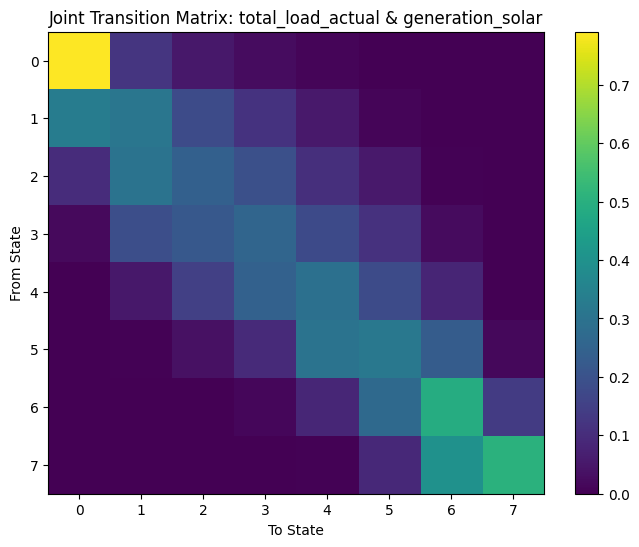


Joint Matrix (total_load_actual & generation_solar) Column Sums:
[1.2443916  0.9773909  0.8755475  0.94945616 1.0290147  1.033349
 1.2283012  0.66254914]

Joint Matrix (total_load_actual & generation_solar) Eigenvalues (Real Part):
[0.99999964 0.8631286  0.646777   0.39666244 0.2049841  0.03908633
 0.03908633 0.01151934]


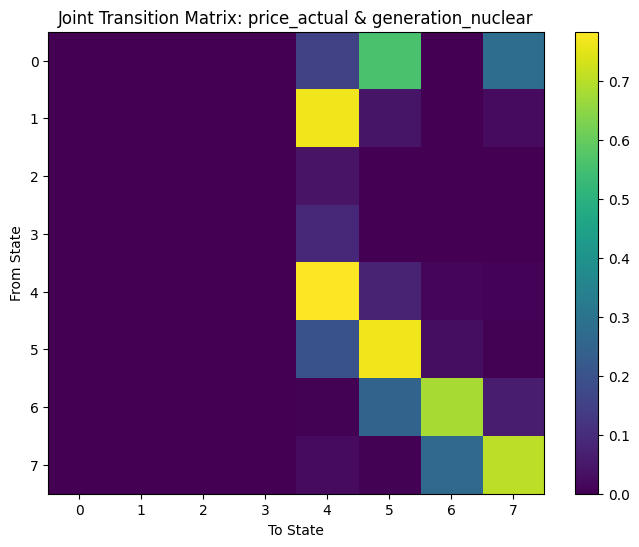


Joint Matrix (price_actual & generation_nuclear) Column Sums:
[3.3686153e-04 2.0152603e-03 0.0000000e+00 0.0000000e+00 2.0609558e+00
 1.7027501e+00 9.8607105e-01 1.0842333e+00]

Joint Matrix (price_actual & generation_nuclear) Eigenvalues (Real Part):
[ 0.0000000e+00  0.0000000e+00 -1.6828091e-04 -1.4104224e-03
  9.4184858e-01  5.4166782e-01  6.7308569e-01  7.8161925e-01]

Conditional Matrix (generation_solar | total_load_actual) Column Sums:
[1.0362772  1.0674542  0.97590053 0.95219237 1.0816159  0.9413231
 1.1165478  0.8286888 ]

Conditional Matrix (generation_solar | total_load_actual) Eigenvalues (Real Part):
[0.37567225 0.5760241  0.6932684  1.0000006  0.97183394 0.93030113
 0.8614117  0.7902876 ]


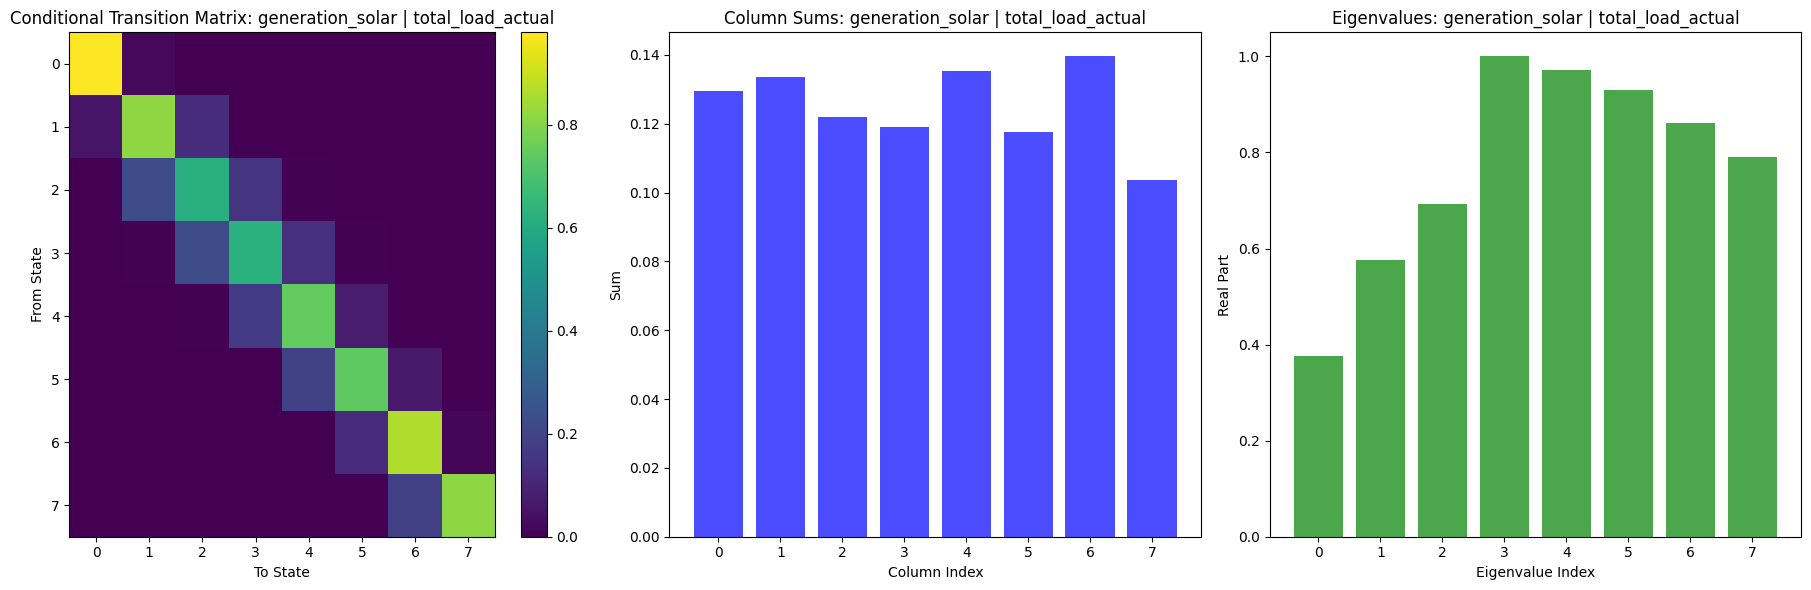


Conditional Matrix (generation_nuclear | price_actual) Column Sums:
[0.         0.         0.         0.         0.99866086 1.0040146
 0.99824333 0.99908113]

Conditional Matrix (generation_nuclear | price_actual) Eigenvalues (Real Part):
[0.9953859  0.9975845  0.9999997  0.99873114 0.         0.
 0.         0.        ]


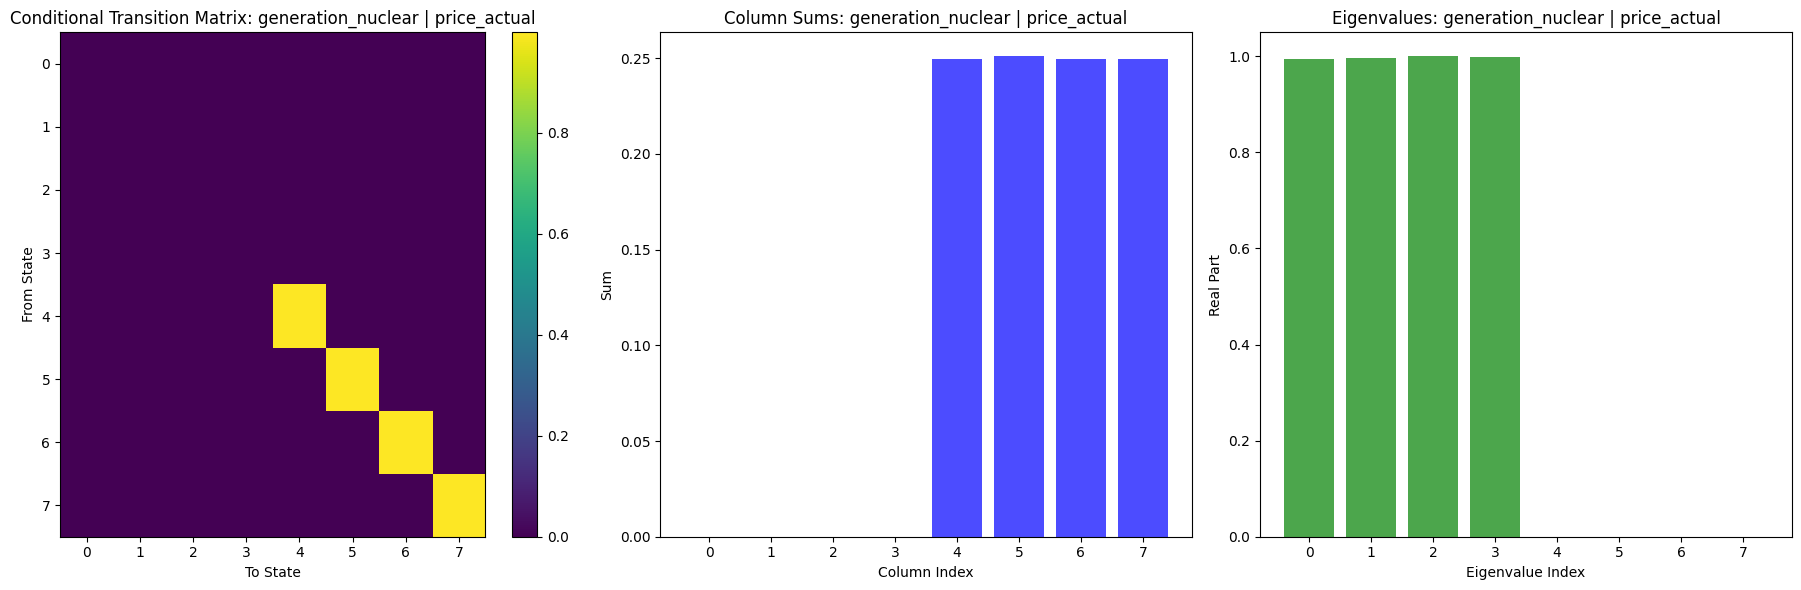


Conditional Matrix (total_load_actual | generation_solar) Column Sums:
[1.0362772  1.0674542  0.97590053 0.95219237 1.0816159  0.9413231
 1.1165478  0.8286888 ]

Conditional Matrix (total_load_actual | generation_solar) Eigenvalues (Real Part):
[0.37567225 0.5760241  0.6932684  1.0000006  0.97183394 0.93030113
 0.8614117  0.7902876 ]


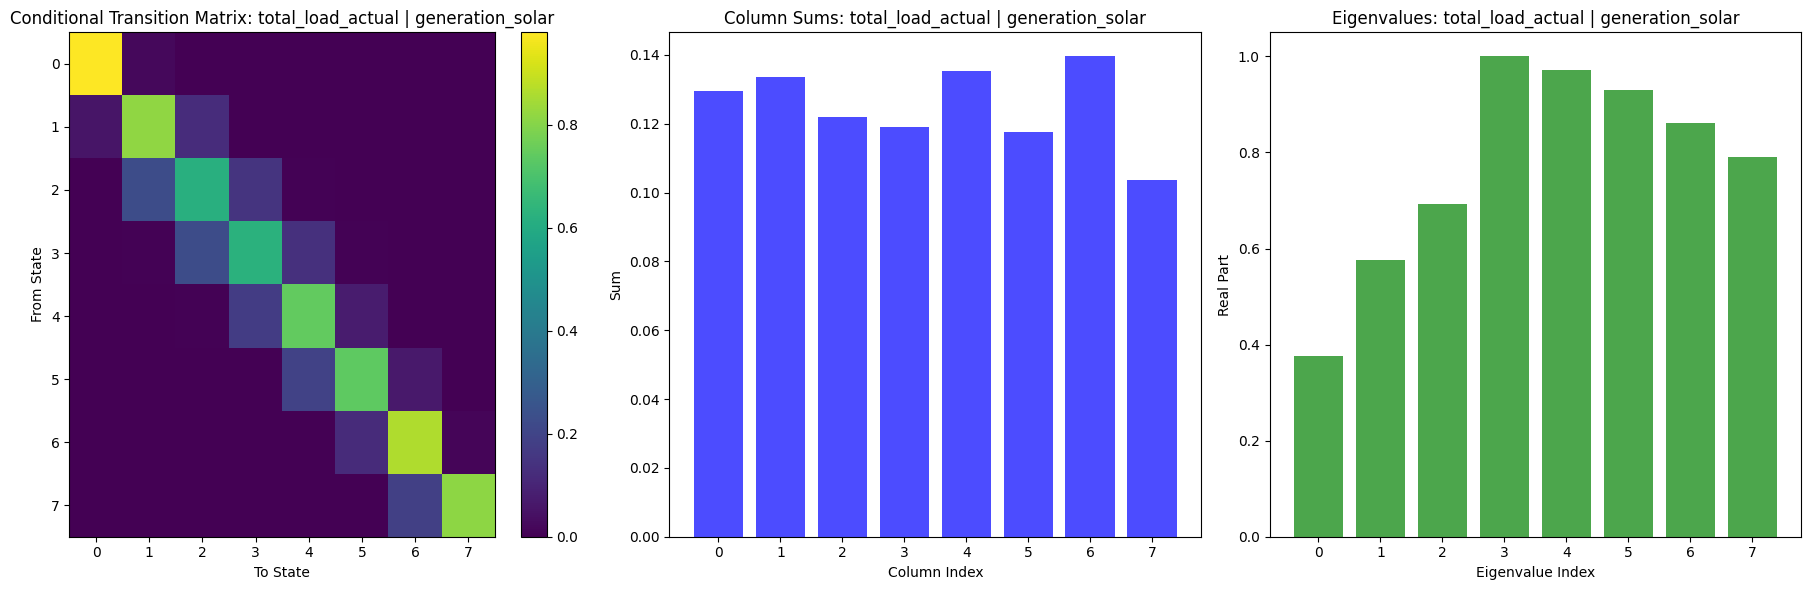


Conditional Matrix (price_actual | generation_nuclear) Column Sums:
[0.         0.         0.         0.         0.99866086 1.0040146
 0.99824333 0.99908113]

Conditional Matrix (price_actual | generation_nuclear) Eigenvalues (Real Part):
[0.9953859  0.9975845  0.9999997  0.99873114 0.         0.
 0.         0.        ]


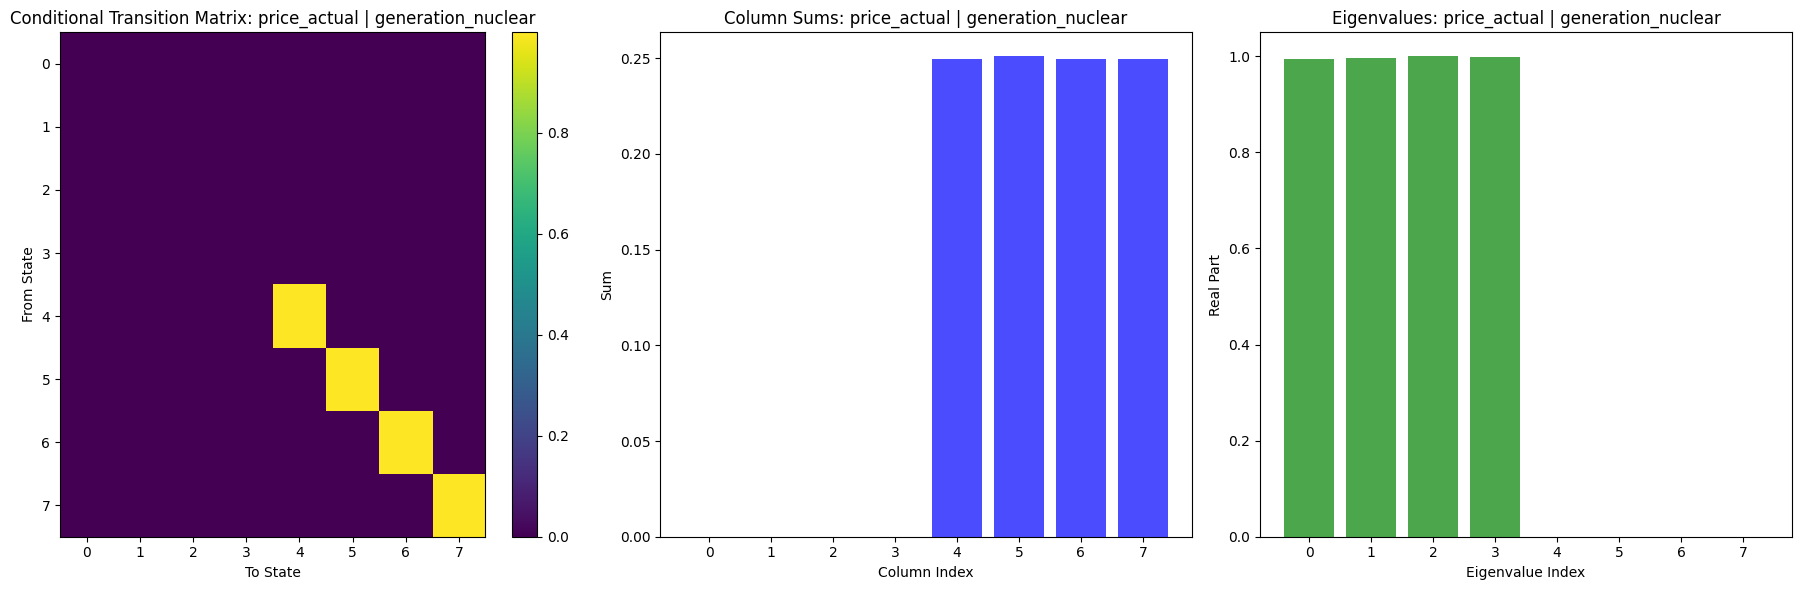

In [22]:

if __name__ == "__main__":
    main()

### inferences

Filas o columnas destacadas:

Una fila con valores uniformes indica que desde ese estado, las transiciones son equiprobables.

Una columna con valores altos sugiere que ese estado es un "atractor" (muchos estados llevan ahí).



---------------
Si la matriz es simétrica  las transiciones son bidireccionales con igual probabilidad.

Si es asimétrica, hay direccionalidad (ejemplo: en un modelo de salud, es más probable pasar de "enfermo" a "sano" que al revés).



Si hay un eigenvalor
λ=1, existe una distribución estacionaria.

Los otros eigenvalores (especialmente si 
∣
λ
∣
<
1
∣λ∣<1) determinan la velocidad de convergencia al equilibrio.

Un eigenvalor dominante (cercano a 1) sugiere que el sistema tiende a un equilibrio.



END